In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv


In [2]:
# import all the tools we need


# Regular EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


# we want our plots to apear within notebooks
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("darkgrid")


# Models from scikit-learn & XGboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2


# Model Evaluation libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score
from sklearn.metrics import plot_roc_curve
# For Hyperparameter tunning of Xgboost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
df = pd.read_csv("../input/vehicle-claim-fraud-detection/fraud_oracle.csv")
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


# EDA (Exploratory Data Analysis)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
WeekOfMonth,15420.00,2.79,1.29,1.00,2.00,3.00,4.00,5.00
WeekOfMonthClaimed,15420.00,2.69,1.26,1.00,2.00,3.00,4.00,5.00
Age,15420.00,39.86,13.49,0.00,31.00,38.00,48.00,80.00
FraudFound_P,15420.00,0.06,0.24,0.00,0.00,0.00,0.00,1.00
PolicyNumber,15420.00,7710.50,4451.51,1.00,3855.75,7710.50,11565.25,15420.00
RepNumber,15420.00,8.48,4.60,1.00,5.00,8.00,12.00,16.00
Deductible,15420.00,407.70,43.95,300.00,400.00,400.00,400.00,700.00
DriverRating,15420.00,2.49,1.12,1.00,1.00,2.00,3.00,4.00
Year,15420.00,1994.87,0.80,1994.00,1994.00,1995.00,1996.00,1996.00


In [6]:
df["FraudFound_P"].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

<AxesSubplot:>

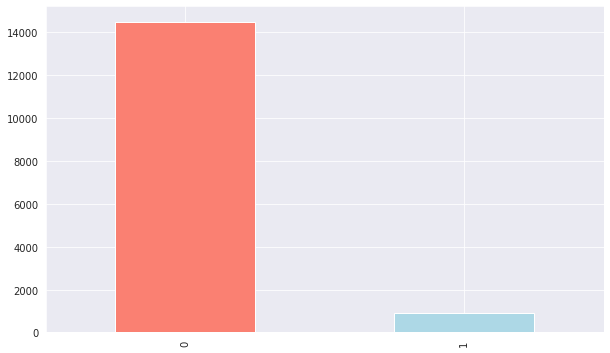

In [7]:
plt.figure(figsize=(10,6))
df["FraudFound_P"].value_counts().plot(kind="bar", color=['salmon', 'lightblue'])

In [8]:
df["Sex"].value_counts()

Male      13000
Female     2420
Name: Sex, dtype: int64

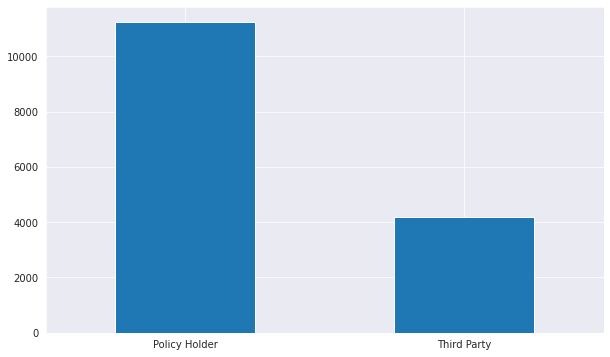

In [9]:
plt.figure(figsize=(10,6))
df["Fault"].value_counts().plot(kind="bar")
plt.xticks(rotation = 0);

In [10]:
df.AccidentArea.value_counts()

Urban    13822
Rural     1598
Name: AccidentArea, dtype: int64

(array([0, 1]), [Text(0, 0, 'Urban'), Text(1, 0, 'Rural')])

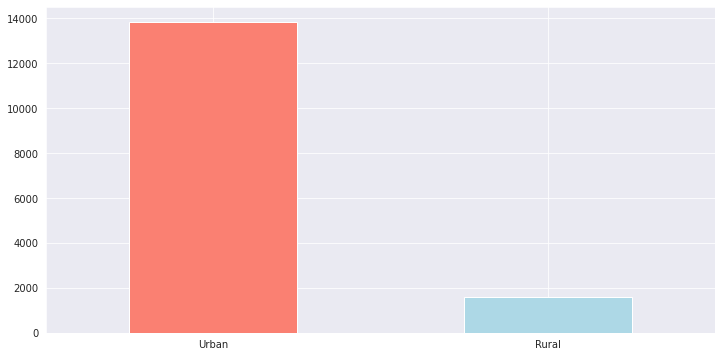

In [11]:
# Let's visualize the AccidentArea
plt.figure(figsize=(12,6))
df.AccidentArea.value_counts().plot(kind="bar",color=["salmon","lightblue"])
plt.xticks(rotation=0)

<AxesSubplot:>

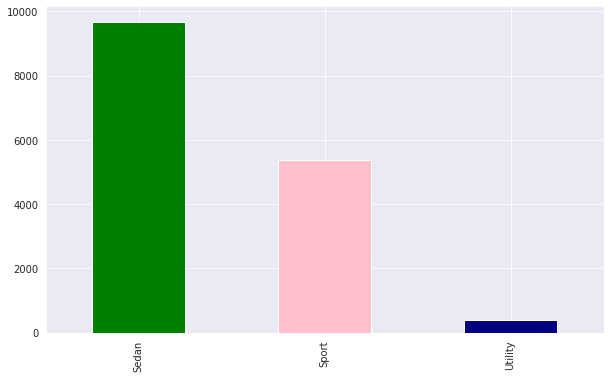

In [12]:
# Let's find out VehicleCategory
plt.figure(figsize=(10,6))
df.VehicleCategory.value_counts().plot(kind="bar",color=["green","pink","navy"])

In [13]:
df.AgeOfVehicle.value_counts()

7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             373
4 years         229
3 years         152
2 years          73
Name: AgeOfVehicle, dtype: int64

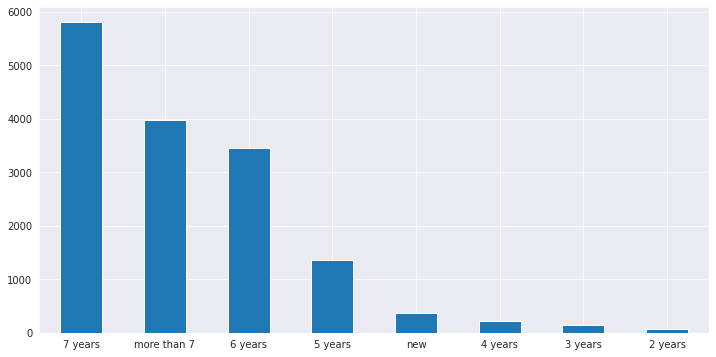

In [14]:
# Let's Visualize the age of Vehicle
plt.figure(figsize=(12,6))
df.AgeOfVehicle.value_counts().plot(kind="bar")
plt.xticks(rotation=0);

In [15]:
df.WitnessPresent.value_counts()

No     15333
Yes       87
Name: WitnessPresent, dtype: int64

<AxesSubplot:>

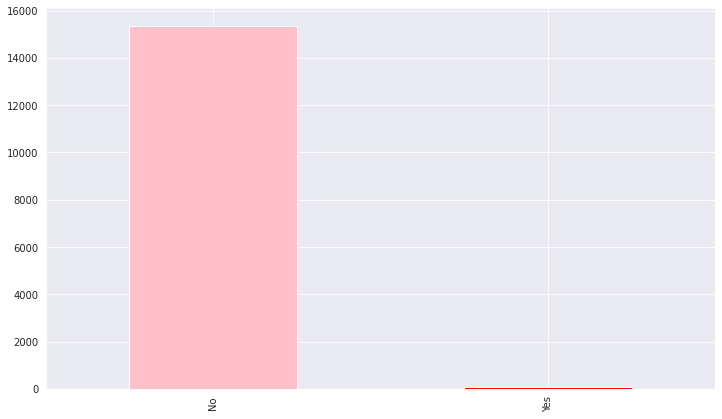

In [16]:
# Let's Visulaize the WitnessPresent On Accident Site
plt.figure(figsize=(12,7))
df.WitnessPresent.value_counts().plot(kind="bar", color=["pink","red"])

In [17]:
df.PoliceReportFiled.value_counts()

No     14992
Yes      428
Name: PoliceReportFiled, dtype: int64

<AxesSubplot:>

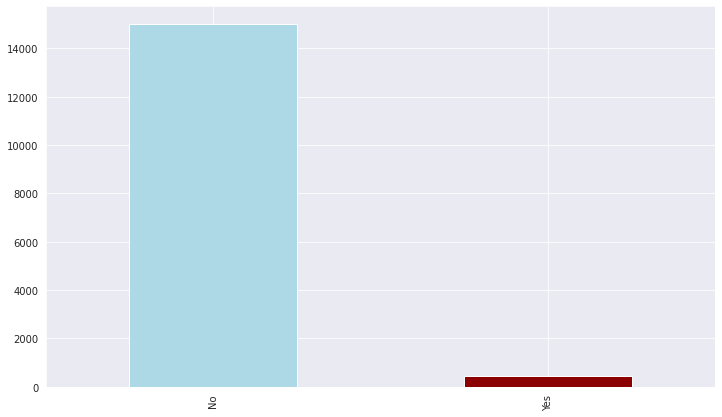

In [18]:
# Let's Check out the Police Report Filed with barplot
plt.figure(figsize=(12,7))
df.PoliceReportFiled.value_counts().plot(kind="bar",color=["lightblue","darkred"])

In [19]:
df.DriverRating.value_counts()

1    3944
3    3884
2    3801
4    3791
Name: DriverRating, dtype: int64

In [20]:
df.VehiclePrice.value_counts()

20000 to 29000     8079
30000 to 39000     3533
more than 69000    2164
less than 20000    1096
40000 to 59000      461
60000 to 69000       87
Name: VehiclePrice, dtype: int64

#### we need find corr() between features

In [21]:
df.corr()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
WeekOfMonth,1.00,0.28,-0.00,-0.01,-0.01,0.01,-0.00,-0.02,-0.00
WeekOfMonthClaimed,0.28,1.00,0.00,-0.01,0.01,0.01,0.01,-0.00,0.01
Age,-0.00,0.00,1.00,-0.03,0.03,-0.01,0.07,0.00,0.03
FraudFound_P,-0.01,-0.01,-0.03,1.00,-0.02,-0.01,0.02,0.01,-0.02
PolicyNumber,-0.01,0.01,0.03,-0.02,1.00,0.01,0.00,-0.01,0.94
RepNumber,0.01,0.01,-0.01,-0.01,0.01,1.00,0.00,0.01,0.01
Deductible,-0.00,0.01,0.07,0.02,0.00,0.00,1.00,0.00,-0.00
DriverRating,-0.02,-0.00,0.00,0.01,-0.01,0.01,0.00,1.00,-0.01
Year,-0.00,0.01,0.03,-0.02,0.94,0.01,-0.00,-0.01,1.00


<AxesSubplot:>

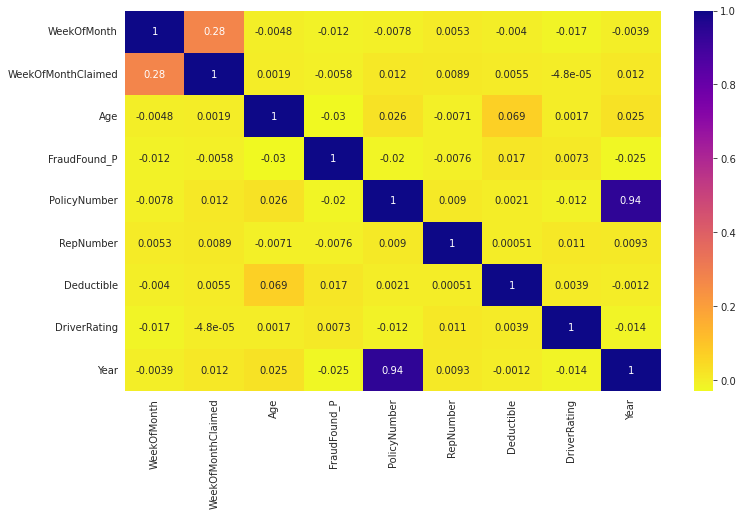

In [22]:
# Let's viualize the corr between independent variables and with dependant (target variable)
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap="plasma_r")

In [23]:
# Let's check it with crosstab 
#(crosstab() function takes two or more lists, pandas series or dataframe columns and returns a frequency of each combination by default)

pd.crosstab(df.FraudFound_P, df.Sex)

Sex,Female,Male
FraudFound_P,,
0,2315,12182
1,105,818


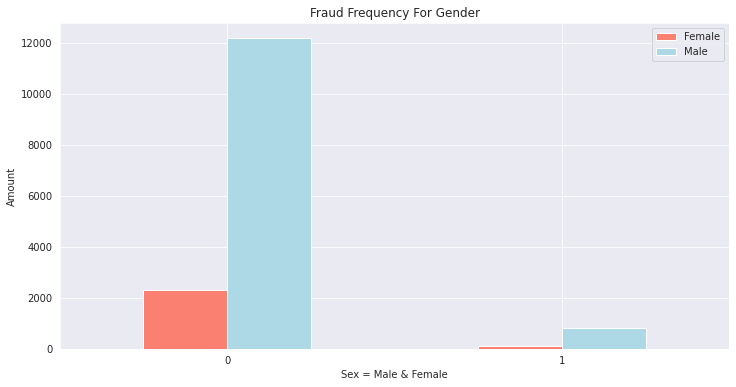

In [24]:
# Create a plot of crosstab for FraudFound and Sex Columns
pd.crosstab(df.FraudFound_P, df.Sex).plot(kind="bar",
                                          color=["salmon","lightblue"],
                                          figsize=(12,6))

plt.title("Fraud Frequency For Gender")
plt.xlabel("Sex = Male & Female")
plt.ylabel("Amount")
plt.legend(["Female","Male"])
plt.xticks(rotation = 0);

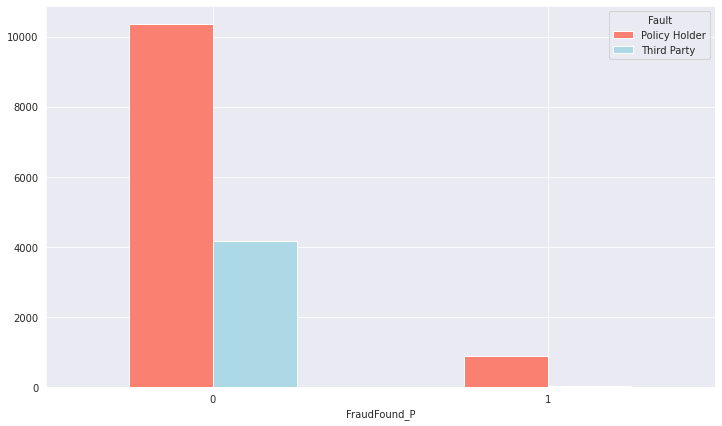

In [25]:
# let's plot 
pd.crosstab(df.FraudFound_P, df.Fault).plot(kind="bar",
                                            color = ["salmon","lightblue"],
                                            figsize=(12,7))
plt.xticks(rotation = 0);

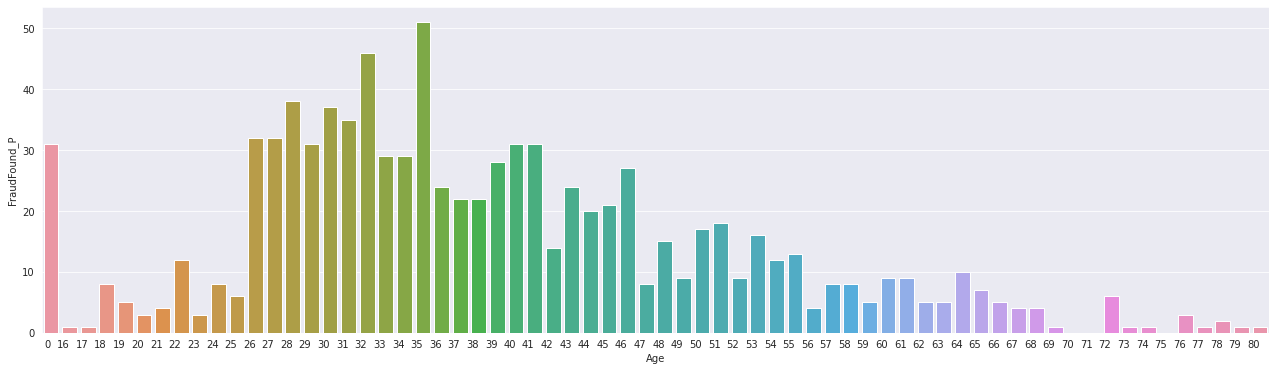

In [26]:
# Let's check FraudFound with Age using barplot
gpd_by_val=df.groupby('Age').agg({'FraudFound_P':'sum'}).reset_index()

fig, (ax1) = plt.subplots(1,1,figsize=(22, 6))
grph =sns.barplot(x='Age', y='FraudFound_P', data = gpd_by_val, ax=ax1)

grph.set_xticklabels(grph.get_xticklabels(),
                    rotation=0,
                    horizontalalignment='right'
                    );

<AxesSubplot:xlabel='Days_Policy_Accident', ylabel='FraudFound_P'>

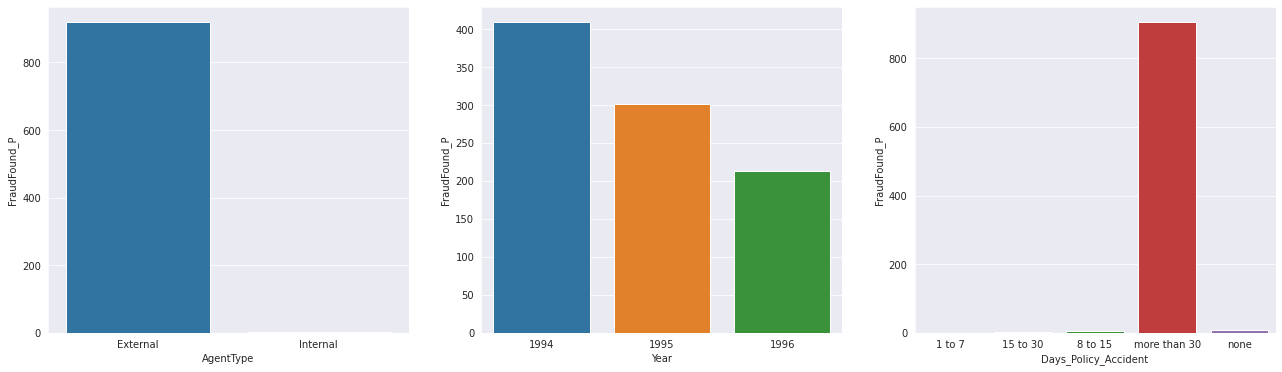

In [27]:
# Let's Check the AgentType, Year, and daysPolicy with FraudFound using barplot
gpd_val1=df.groupby('AgentType').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df.groupby('Year').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val3=df.groupby('Days_Policy_Accident').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22, 6))
sns.barplot(x='AgentType', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='Year', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='Days_Policy_Accident', y='FraudFound_P', data = gpd_val3, ax=ax3)

<AxesSubplot:xlabel='Days_Policy_Claim', ylabel='FraudFound_P'>

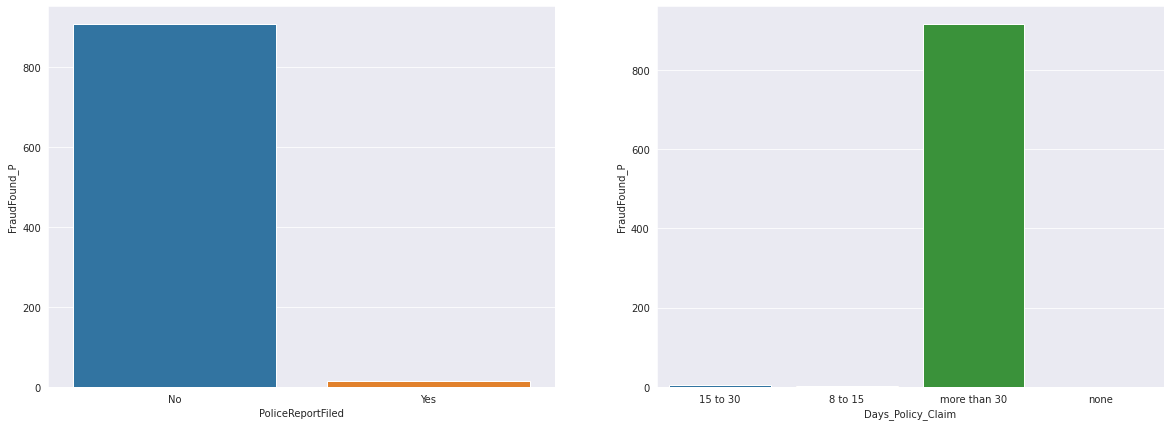

In [28]:
#Let's Plot the PoliceReportFiled, Days_Policy_Claim & DayOfWeek with FraudFound using Barplot
gpd_val4=df.groupby('PoliceReportFiled').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val5=df.groupby('Days_Policy_Claim').agg({'FraudFound_P':'sum'}).reset_index()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 7))
sns.barplot(x='PoliceReportFiled', y='FraudFound_P', data = gpd_val4, ax=ax1)
sns.barplot(x='Days_Policy_Claim', y='FraudFound_P', data = gpd_val5, ax=ax2)

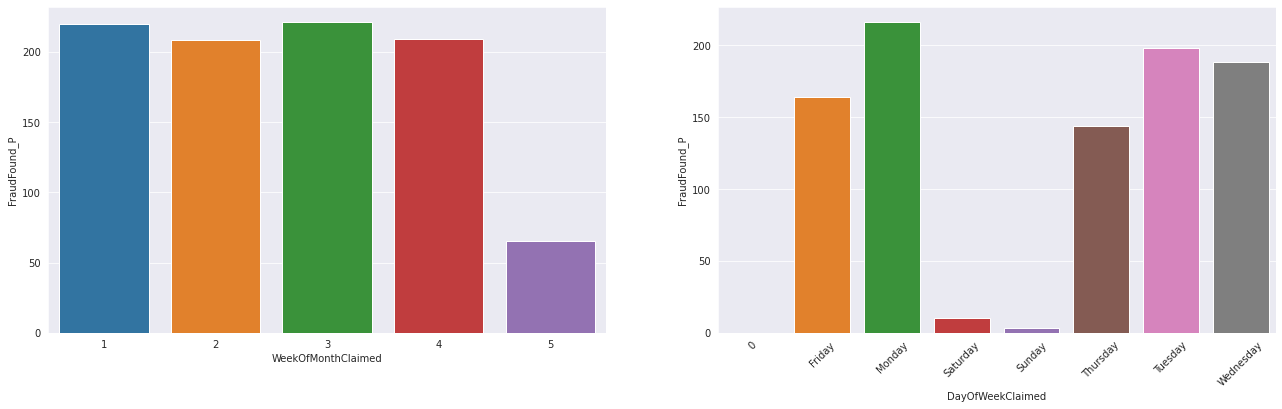

In [29]:
# Let's plot the WitnessPresent, WeekOfMonthClaimed & DayOFWeekClaimed with FraudFound using barplot
gpd_val8=df.groupby('WeekOfMonthClaimed').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val9=df.groupby('DayOfWeekClaimed').agg({'FraudFound_P':'sum'}).reset_index()


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22, 6))
sns.barplot(x='WeekOfMonthClaimed', y='FraudFound_P', data = gpd_val8, ax=ax1)
sns.barplot(x='DayOfWeekClaimed', y='FraudFound_P', data = gpd_val9, ax=ax2)
plt.xticks(rotation=45);

<AxesSubplot:xlabel='WitnessPresent', ylabel='FraudFound_P'>

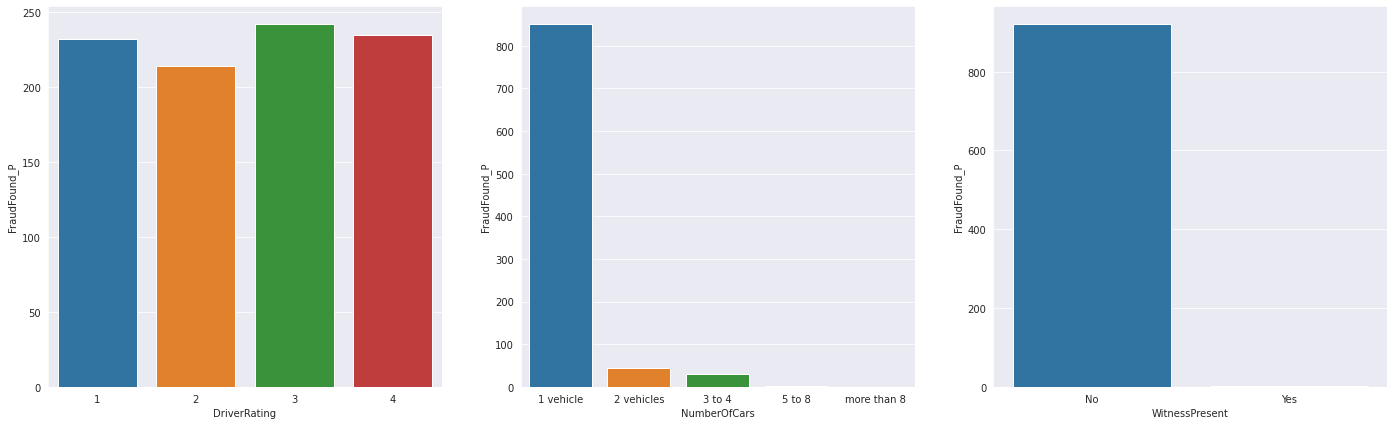

In [30]:
# Let's plot DriverRating, NumberOfCars & WinessPresent with barplot
gpd_val_10 = df.groupby("DriverRating").agg({"FraudFound_P":"sum"}).reset_index()
gpd_val_11 = df.groupby("NumberOfCars").agg({"FraudFound_P":"sum"}).reset_index()
gpd_val_12 = df.groupby("WitnessPresent").agg({"FraudFound_P":"sum"}).reset_index()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,7))

sns.barplot(x="DriverRating", y="FraudFound_P", data = gpd_val_10, ax= ax1)
sns.barplot(x="NumberOfCars", y="FraudFound_P", data = gpd_val_11, ax= ax2)
sns.barplot(x='WitnessPresent', y='FraudFound_P', data = gpd_val_12, ax= ax3)     


<AxesSubplot:xlabel='PastNumberOfClaims', ylabel='FraudFound_P'>

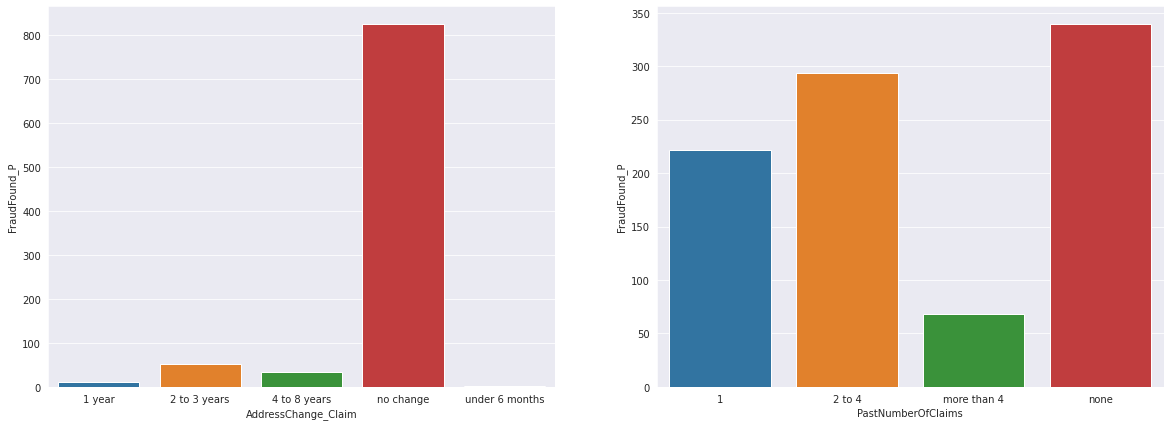

In [31]:
# Let's Plot the AddressChangeClaim & PastNumberOfClaims using Barplot
gpd_val_12 = df.groupby("AddressChange_Claim").agg({"FraudFound_P": "sum"}).reset_index()
gpd_val_13 = df.groupby("PastNumberOfClaims").agg({"FraudFound_P": "sum"}).reset_index()

fig , (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

sns.barplot(x="AddressChange_Claim", y="FraudFound_P", data=gpd_val_12, ax=ax1)
sns.barplot(x="PastNumberOfClaims", y="FraudFound_P", data=gpd_val_13, ax=ax2)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

# Build Model

* First We Need To Remove The 0 Values in Dataset

In [33]:
# We have 0 values only in Age column
print(df['Age'].unique()==0)
len(df[df['Age']==0])

[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


320

In [34]:
# Make a copy of original dataframe for preprocessing
df_temp = df.copy()
# Finding columns which contains strings
for labels, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(labels)

Month
DayOfWeek
Make
AccidentArea
DayOfWeekClaimed
MonthClaimed
Sex
MaritalStatus
Fault
PolicyType
VehicleCategory
VehiclePrice
Days_Policy_Accident
Days_Policy_Claim
PastNumberOfClaims
AgeOfVehicle
AgeOfPolicyHolder
PoliceReportFiled
WitnessPresent
AgentType
NumberOfSuppliments
AddressChange_Claim
NumberOfCars
BasePolicy


In [35]:
# Now Let's Fill 0 value with median of the column
df_temp["Age"] = df_temp["Age"].replace(0,df["Age"].median())

In [36]:
# Let's Check if we have 0 in Age
print(df_temp['Age'].unique()==0)
len(df_temp[df_temp['Age']==0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


0

* Now We Need To Turn All Strings Into Numerical Values For Machine Learning Model

In [37]:
# Now turn all string into categorical features
for labels, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[labels] = content.astype("category").cat.as_ordered()

In [38]:
# Let's Check how many columns changed into Category
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Month                 15420 non-null  category
 1   WeekOfMonth           15420 non-null  int64   
 2   DayOfWeek             15420 non-null  category
 3   Make                  15420 non-null  category
 4   AccidentArea          15420 non-null  category
 5   DayOfWeekClaimed      15420 non-null  category
 6   MonthClaimed          15420 non-null  category
 7   WeekOfMonthClaimed    15420 non-null  int64   
 8   Sex                   15420 non-null  category
 9   MaritalStatus         15420 non-null  category
 10  Age                   15420 non-null  int64   
 11  Fault                 15420 non-null  category
 12  PolicyType            15420 non-null  category
 13  VehicleCategory       15420 non-null  category
 14  VehiclePrice          15420 non-null  category
 15  Fr

In [39]:
# Turn Categorical Features values into numeric
for labels, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing values 
       #df_temp[labels+"_is_missing"] = pd.isnull(content) # Though we don't have but we could've used if we had missing values
        df_temp[labels] = pd.Categorical(content).codes

In [40]:
df_temp.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,2,5,6,6,1,6,5,1,0,2,...,1,3,0,0,0,3,0,2,1994,2
1,4,3,6,6,1,2,5,4,1,2,...,4,4,1,0,0,3,3,0,1994,1
2,10,5,0,6,1,5,10,2,1,1,...,5,6,0,0,0,3,3,0,1994,1
3,6,2,2,17,0,1,6,1,1,1,...,6,7,1,0,0,2,3,0,1994,2
4,4,5,1,6,1,6,4,2,0,2,...,3,4,0,0,0,3,3,0,1994,1


### Now Out Dataset is Ready For Algorithms 

In [41]:
df_temp.describe()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
count,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,...,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00,15420.00
mean,5.53,2.79,2.92,10.11,0.90,4.20,6.60,2.69,0.84,1.30,...,4.80,4.89,0.03,0.01,0.02,2.00,2.89,0.10,1994.87,1.04
std,3.41,1.29,2.06,5.28,0.30,2.27,3.41,1.26,0.36,0.48,...,1.14,1.40,0.16,0.07,0.12,1.11,0.45,0.38,0.80,0.78
min,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1994.00,0.00
25%,3.00,2.00,1.00,6.00,1.00,2.00,4.00,2.00,1.00,1.00,...,4.00,4.00,0.00,0.00,0.00,1.00,3.00,0.00,1994.00,0.00
50%,6.00,3.00,3.00,9.00,1.00,5.00,7.00,3.00,1.00,1.00,...,5.00,5.00,0.00,0.00,0.00,2.00,3.00,0.00,1995.00,1.00
75%,8.00,4.00,5.00,13.00,1.00,6.00,10.00,4.00,1.00,2.00,...,6.00,6.00,0.00,0.00,0.00,3.00,3.00,0.00,1996.00,2.00
max,11.00,5.00,6.00,18.00,1.00,7.00,12.00,5.00,1.00,3.00,...,7.00,8.00,1.00,1.00,1.00,3.00,4.00,4.00,1996.00,2.00


### Splitting Data

In [42]:
# Split data into X & y
X = df_temp.drop("FraudFound_P",axis = 1)
y = df_temp["FraudFound_P"]

In [43]:
X

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,2,5,6,6,1,6,5,1,0,2,...,1,3,0,0,0,3,0,2,1994,2
1,4,3,6,6,1,2,5,4,1,2,...,4,4,1,0,0,3,3,0,1994,1
2,10,5,0,6,1,5,10,2,1,1,...,5,6,0,0,0,3,3,0,1994,1
3,6,2,2,17,0,1,6,1,1,1,...,6,7,1,0,0,2,3,0,1994,2
4,4,5,1,6,1,6,4,2,0,2,...,3,4,0,0,0,3,3,0,1994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,9,4,0,17,1,6,10,5,1,1,...,4,4,0,0,0,3,3,0,1996,1
15416,9,5,4,13,1,1,3,1,1,1,...,4,4,0,0,0,2,3,2,1996,2
15417,9,5,4,17,0,1,3,1,1,2,...,3,3,0,0,0,0,3,0,1996,1
15418,2,1,1,17,1,5,3,2,0,1,...,0,4,0,0,0,2,3,0,1996,0


In [44]:
y

0        0
1        0
2        0
3        0
4        0
        ..
15415    1
15416    0
15417    1
15418    0
15419    1
Name: FraudFound_P, Length: 15420, dtype: int64

In [45]:
# Setup random seed for reproduction
np.random.seed(42)

# Split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2)


In [46]:
# Let's Check our Train and Test Split
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Training target statistics: Counter({0: 11610, 1: 726})
Testing target statistics: Counter({0: 2887, 1: 197})


((12336, 32), (3084, 32), (12336,), (3084,))

## As we can see our Target Feature is totally unbalanced so we would apply scikit-learn function to balance the weight of classes

In [47]:
# Let's import the function
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(
                                                                        class_weight='balanced',
                                                                        classes= np.unique(y_train), 
                                                                        y = y_train)))
class_weights

{0: 0.531266149870801, 1: 8.49586776859504}

In [48]:
# Let's put our models into dictionary 
models = {"Logistic Regression": LogisticRegression(class_weight=class_weights,solver = 'liblinear'),
          "KNN": KNeighborsClassifier(),
          "Random Forest Classifier": RandomForestClassifier(class_weight=class_weights),
          "XGboost": XGBClassifier()}

# Let's create a function to fit and later score our models
def fit_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates the given machine learning models
    """
    # random seed for reproduction
    np.random.seed(42)
    
    # Let's create a empty dictionary to keep model score
    model_score = {}
    
    # Let's loop through the models dictionary
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Evaluate the score and append it
        model_score[name] = model.score(X_test,y_test)
    return model_score

In [49]:
model_score = fit_score(models=models,
                        X_train=X_train,
                        X_test=X_test,
                        y_train=y_train,
                        y_test=y_test)
model_score

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Logistic Regression': 0.6076523994811932,
 'KNN': 0.9315823605706874,
 'Random Forest Classifier': 0.937094682230869,
 'XGboost': 0.9536316472114138}

In [50]:
# Save into DataFrame
model_compare = pd.DataFrame(model_score,index=["Accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest Classifier,XGboost
Accuracy,0.61,0.93,0.94,0.95


<AxesSubplot:>

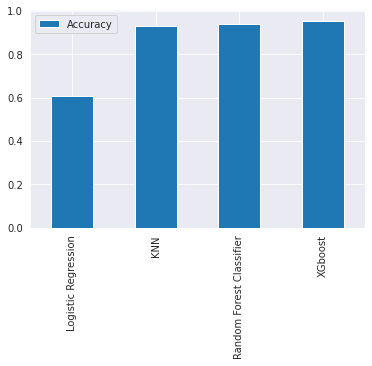

In [51]:
# Let's Plot The Models and Compare
model_compare.T.plot(kind="bar")

### So far three algorithms performed pretty well 

* The first model is not the best model.
Let's tune all the algorithms if we can get more accuracy

In [52]:
# First Let's tune KNN
train_score = []
test_score  = []

# Let's create a list for different neighbors
neighbors = range(1, 21)

# Setup knn instance
knn = KNeighborsClassifier()

# loop through different neighbors
for i in neighbors:
    knn.set_params(n_neighbors = i)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Update the training score list
    train_score.append(knn.score(X_train, y_train))
    
    # Update the test score list
    test_score.append(knn.score(X_test, y_test))

Maximum KNN score on Test data: 93.61%


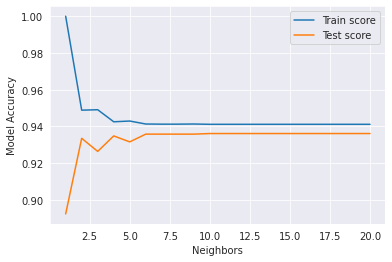

In [53]:
# Let's Plot And Viusalize The KNN Tunned Model
plt.plot(neighbors, train_score, label= "Train score")
plt.plot(neighbors, test_score, label= "Test score")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend()

print(f"Maximum KNN score on Test data: {max(test_score)*100 :.2f}%")

> So far K-nn has not improved so let's jump into another algorithm tunning

> This time we will tune hyperparameter with Scikit-learn libraries `RandomizedSearchCV` & `GridSearchCV`

## Hyperparameter with RandomizedSearchCV

In [54]:
# Create hyperparametergrid for LogisticRegression

log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create hyperparameterGrid for RandomForestClassifier
rf_random_grid = {"n_estimators": np.arange(10,1000,50),
                  "max_depth": [None, 3, 5, 10],
                  "min_samples_split": np.arange(2, 20, 2),
                  "min_samples_leaf": np.arange(1, 20, 2)} 

In [55]:
# Let's Tune LogisticRegression
np.random.seed(42)

# Setup Random Hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(class_weight=class_weights),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.3s finished


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight={0: 0.531266149870801,
                                                              1: 8.49586776859504}),
                   n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [56]:
# Let's Check The Best Parmeters
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.0018329807108324356}

In [57]:
# Let's Score the Tunned model
rs_log_reg.score(X_test, y_test)

0.6809338521400778

* So far Logistic Regression has not improved that much 

In [58]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifer
rf_rs = RandomizedSearchCV(RandomForestClassifier(class_weight=class_weights),
                           param_distributions=rf_random_grid,
                           cv=5,
                           verbose=True,
                           n_iter=10)

# Fitting random hyperparamter search
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 0.531266149870801,
                                                                  1: 8.49586776859504}),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [59]:
# Let's Check The Best Parmeters
rf_rs.best_params_

{'n_estimators': 310,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_depth': None}

In [60]:
# Let's Score the Tunned model
rf_rs.score(X_test, y_test)

0.9341763942931258

In [61]:
# Let's compare it default Models score
model_score

{'Logistic Regression': 0.6076523994811932,
 'KNN': 0.9315823605706874,
 'Random Forest Classifier': 0.937094682230869,
 'XGboost': 0.9536316472114138}

## Let's use GridSearchCV for hyperparameter tunning

In [62]:
# Setup random seed
np.random.seed(42)

# Different  LogisticRegression Hyperparameter
log_reg_grid = {"C": np.logspace(-4,4,30),
              "solver": ["liblinear"]}

# Setup Grid Search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(class_weight=class_weights),
                          param_grid=log_reg_grid,
                          cv = 20,
                          n_jobs=-1,
                          verbose=True)

# Fit the GridSearch instance
gs_log_reg.fit(X_test, y_test)

Fitting 20 folds for each of 30 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   21.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.7s finished


GridSearchCV(cv=20,
             estimator=LogisticRegression(class_weight={0: 0.531266149870801,
                                                        1: 8.49586776859504}),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [63]:
# Let's Check The Best Parameters
gs_log_reg.best_params_

{'C': 0.01610262027560939, 'solver': 'liblinear'}

In [64]:
# Let's score the grid search model of logistic Regression
gs_log_reg.score(X_test,y_test)

0.688715953307393

> Now we can say that Logistic Regression is not the best model for our dataset

## Let's work with XGboost Classifier and see if we can get overall best score

In [65]:
# Let's Create  a dictionary with random Parameters for all XGBoostClassifier parameters
space={
    'objective': 'binary:logistic', 
    'use_label_encoder': False, 
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel' : 1,
    'colsample_bynode' : 1,
    'colsample_bytree' : 1,
    'enable_categorical': False,
    'gamma': hp.uniform('gamma', 0,10),
    'gpu_id': -1,
    'importance_type': None,
    'interaction_constraints': '', 
    'learning_rate': 0.300000012, 
    'max_delta_step': 0,
    'max_depth': hp.randint("max_depth", 10)+3,
    'min_child_weight' : hp.randint('min_child_weight', 4)+1,
    'monotone_constraints': '()',
    'n_estimators': hp.randint('n_estimators', 150)+50,
    'n_jobs': -1,
    'num_parallel_tree':1, 
    'predictor':'auto', 
    'random_state': 0,
    'reg_alpha' : hp.randint('reg_alpha', 10),
    'reg_lambda' : hp.randint('reg_lambda', 10),
    'scale_pos_weight': 1,
    'subsample': 1,
    'tree_method': 'exact',
    'validate_parameters':1,
    'verbosity': None,
    'eval_metric': 'aucpr'
    }

In [66]:
# Let's Define a function for our Space Dictionary and train our model
def objective(space):
    clf_model= XGBClassifier(**space)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf_model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf_model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [67]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.9390402075226978
SCORE:
0.9361219195849546
SCORE:
0.9461738002594033
SCORE:
0.9390402075226978
SCORE:
0.9361219195849546
SCORE:
0.945201037613489
SCORE:
0.9390402075226978
SCORE:
0.9361219195849546
SCORE:
0.9416342412451362
SCORE:
0.9377431906614786
SCORE:
0.9361219195849546
SCORE:
0.9396887159533074
SCORE:
0.9390402075226978
SCORE:
0.9361219195849546
SCORE:
0.941958495460441
SCORE:
0.9361219195849546
SCORE:
0.9377431906614786
SCORE:
0.9361219195849546
SCORE:
0.9507133592736705
SCORE:
0.9361219195849546
SCORE:
0.9552529182879378
SCORE:
0.9503891050583657
SCORE:
0.9445525291828794
SCORE:
0.9523346303501945
SCORE:
0.9494163424124513
SCORE:
0.9474708171206225
SCORE:
0.9442282749675746
SCORE:
0.9520103761348897
SCORE:
0.9374189364461738
SCORE:
0.9361219195849546
SCORE:
0.954928664072633
SCORE:
0.9490920881971465
SCORE:
0.9390402075226978
SCORE:
0.9542801556420234
SCORE:
0.9390402075226978
SCORE:
0.943579766536965
SCORE:
0.9390402075226978
SCORE:
0.9422827496757458
SCORE:
0.9361219

In [68]:
# Let's Check the best hyperparameters
best_hyperparams

{'gamma': 1.3119030461351664,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 58,
 'reg_alpha': 2,
 'reg_lambda': 0}

In [69]:
# Let's Create The optimized model with best hyperparameters of XGboost Classifier
clf_model_optimizied = XGBClassifier(
    objective= 'binary:logistic', 
    use_label_encoder= False, 
    base_score= 0.5, 
    booster= 'gbtree', 
    colsample_bylevel= 1, 
    colsample_bynode= 1, 
    colsample_bytree= 1, 
    enable_categorical= False, 
    gamma= best_hyperparams['gamma'], 
    gpu_id= -1, 
    importance_type= None, 
    interaction_constraints= '', 
    learning_rate= 0.300000012, 
    max_delta_step= 0, 
    max_depth= best_hyperparams['max_depth'], 
    min_child_weight= best_hyperparams['min_child_weight'], 
    monotone_constraints= '()',
    n_estimators= best_hyperparams['n_estimators'], 
    n_jobs= 4, 
    num_parallel_tree= 1, 
    predictor= 'auto', 
    random_state= 0, 
    reg_alpha= best_hyperparams['reg_alpha'], 
    reg_lambda= best_hyperparams['reg_lambda'], 
    scale_pos_weight= 1, 
    subsample= 1, 
    tree_method= 'exact', 
    validate_parameters= 1, 
    verbosity= None, 
    eval_metric= 'aucpr'
)
print(clf_model_optimizied.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 1.3119030461351664, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 58, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 2, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'aucpr'}


In [70]:
# Let's Fit our optimized model
xgb_model = clf_model_optimizied.fit(X_train, y_train)

In [71]:
# Let's Predict on our Optimized model
y_preds = xgb_model.predict(X_test)
y_preds

array([0, 0, 0, ..., 0, 0, 0])

## Evaluating our tunned machine learning classifier, beyond accuracy 

* ROC curve and AUC Score
* Confusion matrix
* Classification report 
* Precision 
* Recall
* F1-Score

and it would be great if Cross-validation used if possible

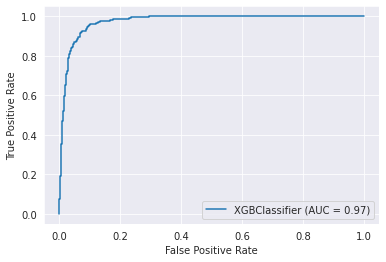

In [72]:
# Let's plot ROC Curve and calculate the AUC metric
plot_roc_curve(xgb_model, X_test,y_test);

In [73]:
print(confusion_matrix(y_test,y_preds))

[[2870   17]
 [ 131   66]]


In [74]:
print(classification_report(y_test,y_preds));

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2887
           1       0.80      0.34      0.47       197

    accuracy                           0.95      3084
   macro avg       0.88      0.66      0.72      3084
weighted avg       0.95      0.95      0.94      3084



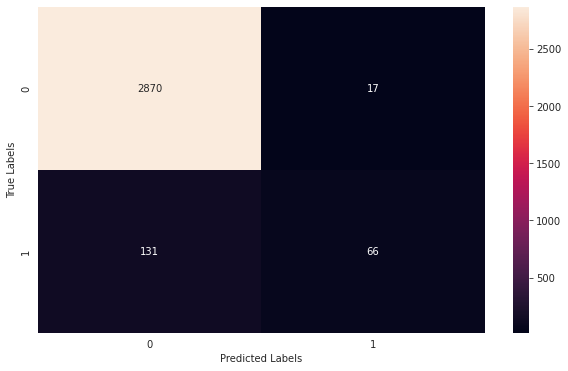

In [75]:
# Let's visualize the confusion matrix

def conf_plot(y_test, y_preds):
    """
    Plots a nice looking heatmap on seaborn
    """
    fix, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=True,
                     fmt="g");
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

conf_plot(y_test, y_preds)  

## Let's calculate the evaluation matrix using cross-validation

#### We're going to calculate Accuracy, precision, recall, and f1-score of our model using cross-validattion and to do so we'll 

#### be using `cross_val_score()`

In [76]:
# Checking the best_parameters
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 1.3119030461351664,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 58,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 2,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'aucpr'}

In [77]:
# Creating a new classifier with best parameters

final_clf_xgb = XGBClassifier(objective= 'binary:logistic', 
                              use_label_encoder= False, 
                              base_score= 0.5, 
                              booster= 'gbtree', 
                              colsample_bylevel= 1, 
                              colsample_bynode= 1, 
                              colsample_bytree= 1, 
                              enable_categorical= False, 
                              gamma= best_hyperparams['gamma'], 
                              gpu_id= -1, 
                              importance_type= None, 
                              interaction_constraints= '', 
                              learning_rate= 0.300000012, 
                              max_delta_step= 0, 
                              max_depth= 8, 
                              min_child_weight= 0, 
                              monotone_constraints= '()',
                              n_estimators= 41, 
                              n_jobs= 4, 
                              num_parallel_tree= 1, 
                              predictor= 'auto', 
                              random_state= 0, 
                              reg_alpha= 2, 
                              reg_lambda= 1, 
                              scale_pos_weight= 1, 
                              subsample= 1, 
                              tree_method= 'exact', 
                              validate_parameters= 1, 
                              verbosity= None, 
                              eval_metric= 'aucpr')

In [78]:
import warnings
warnings.filterwarnings("ignore")

# Cross-validated accuracy
cv_acc = cross_val_score(final_clf_xgb,
                         X,
                         y,
                         cv=100,
                         scoring="accuracy")
# Let's take over all mean of the accuracy
cv_acc = np.mean(cv_acc)
print(f"The Accuracy for our XGboost Classifier is: {cv_acc : .2f}%")


# Cross-validated Precision
cv_precision = cross_val_score(final_clf_xgb,
                         X,
                         y,
                         cv = 100,
                         scoring="precision")
# Let's take over all mean of the Precision
cv_precision = np.mean(cv_precision)
print(f"The Precision for our XGboost Classifier is: {cv_precision : .2f}%")


# Cross-validated Recall
cv_recall = cross_val_score(final_clf_xgb,
                         X,
                         y,
                         cv = 100,
                         scoring="recall")
# Let's take over all mean of the Recall
cv_recall = np.mean(cv_recall)
print(f"The Recall for our XGboost Classifier is: {cv_recall : .2f}%")


# Cross-validated f1-score
cv_f1 = cross_val_score(final_clf_xgb,
                         X,
                         y,
                         cv = 100,
                         scoring="f1")
# Let's take over all mean of the Precision
cv_f1 = np.mean(cv_f1)
print(f"The f1-score for our XGboost Classifier is:{cv_f1 :.2f}%")

The Accuracy for our XGboost Classifier is:  0.94%
The Precision for our XGboost Classifier is:  0.43%
The Recall for our XGboost Classifier is:  0.17%
The f1-score for our XGboost Classifier is:0.22%


In [79]:
print(classification_report(y_test,y_preds));

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2887
           1       0.80      0.34      0.47       197

    accuracy                           0.95      3084
   macro avg       0.88      0.66      0.72      3084
weighted avg       0.95      0.95      0.94      3084



### The reason Why we have less Accuracy, Precsion, Recall, and f1-score is because we have used cv=100 we can gain more if we increase the number of cv(cross-validation).

In [80]:
# Let's Fit the final optimized model
final_clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=1.3119030461351664, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=41, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=2, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [81]:
# Check coeffeficient eg.(how the independent variables (X_train) contributes to predict target variable (y))
final_clf_xgb.feature_importances_

array([0.04293327, 0.01852248, 0.01982655, 0.01515037, 0.02527835,
       0.01665062, 0.03662683, 0.01788182, 0.00853795, 0.01381599,
       0.02065297, 0.21514466, 0.02559943, 0.        , 0.02056077,
       0.04741647, 0.01354041, 0.02574451, 0.01674747, 0.01633176,
       0.01207859, 0.01446822, 0.01947848, 0.04747902, 0.01295713,
       0.        , 0.        , 0.01868371, 0.04391021, 0.02033884,
       0.        , 0.19364305], dtype=float32)

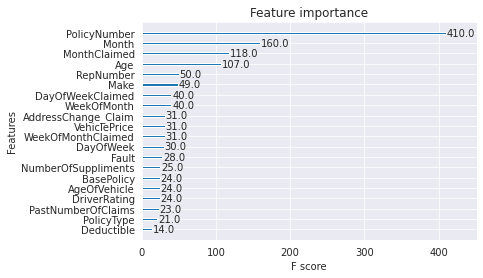

In [82]:
# Here we will plot the F-Score with Features using XGboost built-in function
plot_importance(final_clf_xgb, max_num_features=20);

In [83]:
# Helper function for plotting feature importance of our XGboost Classifier
# We would only plot first top 20 features
def plot_features(columns, importances, n=20):
    df_feat = (pd.DataFrame({"features":columns,
                             "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots(figsize=(12,7))
    ax.barh(df_feat["features"][:n], df_feat["features_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

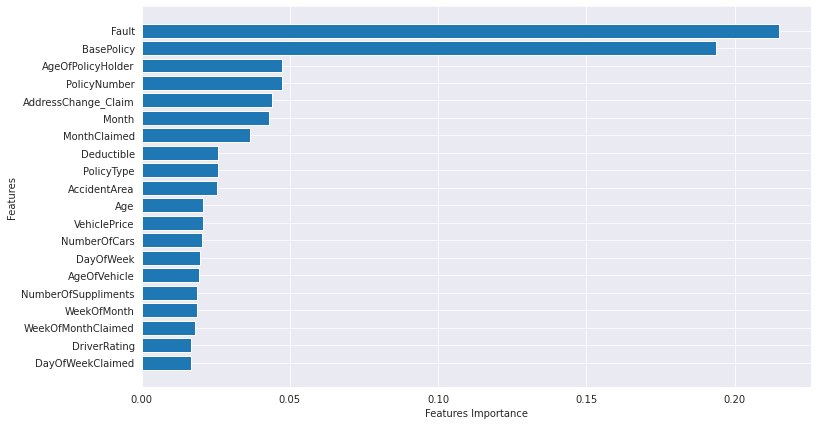

In [84]:
plot_features(X_train.columns, final_clf_xgb.feature_importances_)

* We used many Algorithms but so far XGboost performed pretty well on this dataset though we have un-balanced data(only Target feature).
